# All the parameters that need to be changed

In [1]:
# Missouri
state_ab = "mo"

## Data
1. Download all the data in directory "mo_data"
2. Eextract them all

In [2]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/5799H_02T.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/2022_JRC_Senate_Redistricting_Plan.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/HIBCC Final Apportionment Plan 2.shp".format(data_folder, state_ab)
county_data = "./{}{}_cvap_2022_cnty/{}_cvap_2022_cnty.shp".format(data_folder, state_ab, state_ab)

## Parameters that needs to be manually checked

### base vest data
start_col = 5\
vest_base_data = vest20\
year = '20'

### district data
district column name of cong_df, send, hdist when calling add_dist()

# Program starts

In [3]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph
import os

maup.progress.enabled = True

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [9]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [10]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [11]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

## Read the census data

In [12]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [13]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [14]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [15]:
maup.doctor(population_df)

100%|████████████████████████████████████████████████████████████| 253632/253632 [02:39<00:00, 1585.40it/s]


True

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
               'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
               'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

In [18]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['NH_WHITE'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['NH_BLACK'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['NH_AMIN'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['NH_ASIAN'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['NH_NHPI'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['NH_OTHER'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['NH_2MORE'], 1)

Make sure that the County shapefile is clean:

In [19]:
maup.doctor(county_df)

100%|██████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1459.30it/s]


True

# Read the base vest data
Now using it as a "base precinct", but it could be vest 18 or vest 16 if vest 20 is not working

### Check if vest 20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)

In [21]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PRECBLA', 'G20GOVRPAR', 'G20GOVDGAL', 'G20GOVLCOM',
       'G20GOVGBAU', 'G20LTGRKEH', 'G20LTGDCAN', 'G20LTGLSLA', 'G20LTGGDRA',
       'G20ATGRSCH', 'G20ATGDFIN', 'G20ATGLBAB', 'G20SOSRASH', 'G20SOSDFAL',
       'G20SOSLFRE', 'G20SOSGLEH', 'G20SOSCVEN', 'G20TRERFIT', 'G20TREDENG',
       'G20TRELKAS', 'G20TREGCIV', 'geometry'],
      dtype='object')

## Parameters that need to be checked

In [22]:
start_col = 3
vest_base_data = vest20
year = '20'

In [23]:
# vest_base = add_vest_base(vest_base_data, start_col, year)
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1460.08it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 87.74it/s]


Identifying overlaps...


100%|██████████████████████████████████████████████████████████████| 21731/21731 [00:12<00:00, 1740.67it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 4: 100%|██████████████████████████████████████| 115/115 [00:01<00:00, 72.87it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 9: 100%|█████████████████████████████████████| 203/203 [00:01<00:00, 112.16it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 12: 100%|███████████████████████████████████████| 79/79 [00:01<00:00, 64.48it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|███████████████████████████████████████| 63/63 [00:01<00:00, 53.88it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 16: 100%|█████████████████████████████████████| 275/275 [00:04<00:00, 59.36it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 17: 100%|█████████████████████████████████████| 352/352 [00:05<00:00, 61.80it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 24: 100%|████████████████████████████████████| 292/292 [00:02<00:00, 122.29it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simpl

Let's look at the border lengths.  If there's a clear reasonable cutoff for switching rook adjacencies to queen, we use that.  Otherwise, we can use 30.5 m (which is approximately 100 ft).  This is not a magic number, just a reasonable one.

In [24]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:3000])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

It's not clear what the cutoff should be here; let's use 30.5.

In [25]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████████████████████████| 4299/4299 [00:01<00:00, 3724.65it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|████████████████████████████████████████████████████████████████| 3733/3733 [00:03<00:00, 1187.86it/s]


In [26]:
maup.doctor(vest_base)

100%|████████████████████████████████████████████████████████████████| 3733/3733 [00:03<00:00, 1239.07it/s]


True

### If it is true for maup doctor, we will use it as the base vest data.

In [27]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|█████████████████████████████████████████████████████████████████| 3733/3733 [00:18<00:00, 204.23it/s]


In [28]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
# election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")
election_df = gpd.GeoDataFrame(vest_base)

### Check if the population agrees

In [31]:
check_population(population_df, vest_base)

population agrees


# Add more vest data

In [32]:
vest18 = gpd.read_file(vest18_data)

In [33]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'NAME', 'G18USSRHAW', 'G18USSDMCC', 'G18USSLCAM',
       'G18USSGCRA', 'G18USSIODE', 'G18AUDRMCD', 'G18AUDDGAL', 'G18AUDLOTO',
       'G18AUDGFIT', 'G18AUDCLUE', 'geometry'],
      dtype='object')

In [34]:
# check the result here
start_col = 3
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|████████████████████████████████████████████████████████████████| 3274/3274 [00:03<00:00, 1074.25it/s]


There are 8 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████████████████████████| 3974/3974 [00:01<00:00, 3329.65it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████| 3733/3733 [00:18<00:00, 204.21it/s]


population agrees


### vest 16

In [35]:
vest16 = gpd.read_file(vest16_data)
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'NAME', 'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PRECCAS', 'G16USSRBLU', 'G16USSDKAN', 'G16USSLDIN',
       'G16USSGMCF', 'G16USSCRYM', 'G16GOVRGRE', 'G16GOVDKOS', 'G16GOVLSPR',
       'G16GOVGFIT', 'G16GOVITUR', 'G16LTGRPAR', 'G16LTGDCAR', 'G16LTGLHED',
       'G16LTGGLEA', 'G16ATGRHAW', 'G16ATGDHEN', 'G16TRERSCH', 'G16TREDBAK',
       'G16TRELOTO', 'G16TREGHEX', 'G16SOSRASH', 'G16SOSDSMI', 'G16SOSLMOR',
       'geometry'],
      dtype='object')

In [36]:
start_col = 3
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|█████████████████████████████████████████████████████████████████| 3324/3324 [00:04<00:00, 791.90it/s]


There are 83 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████████████████████████| 4113/4113 [00:01<00:00, 3277.62it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████| 3733/3733 [00:18<00:00, 206.33it/s]


population agrees


## Add the district data

In [37]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [38]:
cong_df.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,DISTRICT_L,geometry
0,1,258.333252,1,1.0,None,None,769364,769364.0,0.0,0.0,1|0%,"POLYGON ((724277.586 4283686.068, 724274.779 4..."
1,2,1819.885010,2,1.0,None,None,769364,769364.0,0.0,0.0,2|0%,"POLYGON ((701455.029 4293272.208, 701452.376 4..."
2,3,7692.436030,3,1.0,None,None,769364,769364.0,0.0,0.0,3|0%,"POLYGON ((702548.398 4312073.906, 702579.992 4..."
3,4,14654.767500,4,1.0,None,None,769364,769364.0,0.0,0.0,4|0%,"POLYGON ((526619.724 4230493.997, 526488.229 4..."
4,5,431.047668,5,1.0,None,None,769364,769364.0,0.0,0.0,5|0%,"POLYGON ((389062.782 4299248.855, 388244.676 4..."


In [39]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,...,F_PERFINDE,PERFINDEX1,F_PERFIND1,PERFINDEX2,PERFINDEX3,F_PERFIND2,PERFINDEX4,F_PERFIND3,PERFINDEX5,geometry
0,2,80.03,SD14,1.0,None,None,185861,181027.0,4834.0,0.0267,...,0.7887,160258.5738,0.2113,758581.3127,376688.6996,0.7817,105199.5418,0.2183,481888.2414,"POLYGON ((736396.121 4288963.569, 736373.196 4..."
1,4,83.23,SD13,1.0,None,None,185863,181027.0,4836.0,0.0267,...,0.8166,140598.1802,0.1834,766789.8417,393529.0964,0.8131,90441.8049,0.1869,483970.9013,"POLYGON ((736264.894 4288133.156, 736233.396 4..."
2,8,45.07,SD5,1.0,None,None,180730,181027.0,-297.0,-0.0016,...,0.9115,57341.6639,0.0885,647598.4425,363370.7868,0.9035,38809.0459,0.0965,402179.8327,"POLYGON ((746182.472 4295370.706, 746174.577 4..."
3,10,34.31,SD4,1.0,None,None,184241,181027.0,3214.0,0.0178,...,0.7292,217849.0733,0.2708,804505.1674,395167.0106,0.7315,145053.8345,0.2685,540220.8451,"POLYGON ((740384.202 4276517.298, 740467.557 4..."
4,12,59.94,SD1,1.0,None,None,184853,181027.0,3826.0,0.0211,...,0.5449,374550.2798,0.4551,823017.8952,301769.0488,0.5374,259731.8251,0.4626,561500.8739,"POLYGON ((728278.587 4263539.062, 728280.525 4..."


In [40]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,DISTRICT_L,Dist_Num,Class,geometry
0,1,2387.352050,1,1.0,None,None,36931,37760.0,-829.0,-0.021954,1|-2.2%,1,1,"POLYGON ((361855.540 4492456.329, 361830.526 4..."
1,2,23.070000,10,1.0,None,None,37451,37760.0,-309.0,-0.008200,10|-0.82%,10,2,"POLYGON ((339394.602 4409561.901, 339518.218 4..."
2,3,11.047083,100,1.0,None,None,37955,37760.0,195.0,0.005164,100|0.52%,100,1,"POLYGON ((712638.891 4274406.918, 712624.069 4..."
3,4,26.420000,101,1.0,None,None,37597,37760.0,-163.0,-0.004300,101|-0.43%,101,2,"POLYGON ((701966.660 4282321.634, 701979.733 4..."
4,5,201.246994,102,1.0,None,None,36867,37760.0,-893.0,-0.023649,102|-2.36%,102,1,"POLYGON ((705493.564 4292427.049, 705595.415 4..."


In [41]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 10.00it/s]


In [42]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 37.16it/s]


In [43]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|████████████████████████████████████████████████████████████████████| 163/163 [00:01<00:00, 97.92it/s]


In [44]:
list(election_df.columns)

['2MOREVAP',
 'AMINVAP',
 'ASIANVAP',
 'ATG16D',
 'ATG16R',
 'ATG20D',
 'ATG20O',
 'ATG20R',
 'AUD18D',
 'AUD18O',
 'AUD18R',
 'BVAP',
 'COUNTYFP',
 'GOV16D',
 'GOV16O',
 'GOV16R',
 'GOV20D',
 'GOV20O',
 'GOV20R',
 'HISP',
 'HVAP',
 'H_2MORE',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'LTG16D',
 'LTG16O',
 'LTG16R',
 'LTG20D',
 'LTG20O',
 'LTG20R',
 'NAME',
 'NHPIVAP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'OTHERVAP',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'SOS16D',
 'SOS16O',
 'SOS16R',
 'SOS20D',
 'SOS20O',
 'SOS20R',
 'STATEFP',
 'TOTPOP',
 'TRE16D',
 'TRE16O',
 'TRE16R',
 'TRE20D',
 'TRE20O',
 'TRE20R',
 'USS16D',
 'USS16O',
 'USS16R',
 'USS18D',
 'USS18O',
 'USS18R',
 'VAP',
 'WVAP',
 'geometry',
 'CD',
 'SEND',
 'HDIST']

### Put the base precinct year after the precinct information column

In [45]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'PRECINCT':'PRECINCT'+year,
        'GEOID':'GEOID'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [46]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    # 'PRECINCT'+year,
    # 'GEOID'+year,
    'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [47]:
list(election_df.columns)

['STATEFP20',
 'COUNTYFP20',
 'NAME20',
 'CD',
 'SEND',
 'HDIST',
 'TOTPOP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'HISP',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'ATG16D',
 'ATG16R',
 'ATG20D',
 'ATG20O',
 'ATG20R',
 'AUD18D',
 'AUD18O',
 'AUD18R',
 'GOV16D',
 'GOV16O',
 'GOV16R',
 'GOV20D',
 'GOV20O',
 'GOV20R',
 'LTG16D',
 'LTG16O',
 'LTG16R',
 'LTG20D',
 'LTG20O',
 'LTG20R',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'SOS16D',
 'SOS16O',
 'SOS16R',
 'SOS20D',
 'SOS20O',
 'SOS20R',
 'TRE16D',
 'TRE16O',
 'TRE16R',
 'TRE20D',
 'TRE20O',
 'TRE20R',
 'USS16D',
 'USS16O',
 'USS16R',
 'USS18D',
 'USS18O',
 'USS18R',
 'geometry']

In [48]:
# store the result in directory "mo"
os.makedirs("./{}".format(state_ab), exist_ok=True)
election_df.to_file("./{}/{}.shp".format(state_ab, state_ab))
election_df.to_file('./{}/{}.geojson'.format(state_ab, state_ab), driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file("./{}/{}.shp".format(state_ab, state_ab), ignore_errors=True)
graph.to_json("./{}/{}.json".format(state_ab, state_ab))

<Axes: >

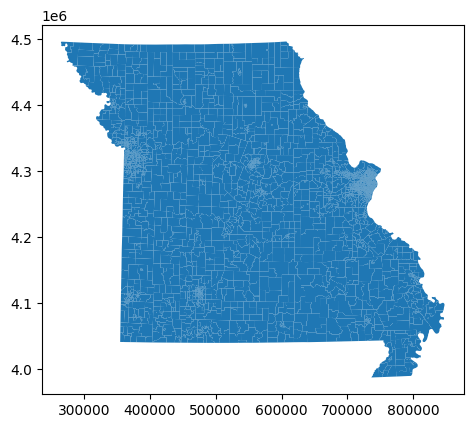

In [49]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()